In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

In [2]:
df = pd.read_csv('./data/telco_clean.csv')

print(f"Shape of dataset: {df.shape}")
df.head()

Shape of dataset: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,NaN,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,NaN,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,NaN,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,NaN,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,NaN,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [3]:
X = df.drop('Churn', axis=1)
y = df['Churn']

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    X[col] = X[col].map({'Yes': 1, 'No': 0})

if 'gender' in X.columns:
    X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})

multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
              'OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

encoder = OneHotEncoder(drop='first', sparse=False)
encoded_multi = encoder.fit_transform(X[multi_cols])
encoded_cols = encoder.get_feature_names_out(multi_cols)
encoded_df = pd.DataFrame(encoded_multi, columns=encoded_cols, index=X.index)

X = X.drop(multi_cols, axis=1)
X = pd.concat([X, encoded_df], axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X[num_cols] = scaler.fit_transform(X[num_cols])

joblib.dump(encoder, './models/encoder.pkl')
joblib.dump(scaler, './models/scaler.pkl')

['./models/scaler.pkl']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

test_data = X_test.copy()
test_data['Churn'] = y_test

test_data.to_csv('./data/test_data.csv', index=False)

Train size: 5634, Test size: 1409


In [6]:
model = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    class_weight='balanced',   
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(class_weight='balanced', max_depth=5, random_state=42)

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.53      0.79      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.76      0.77      1409



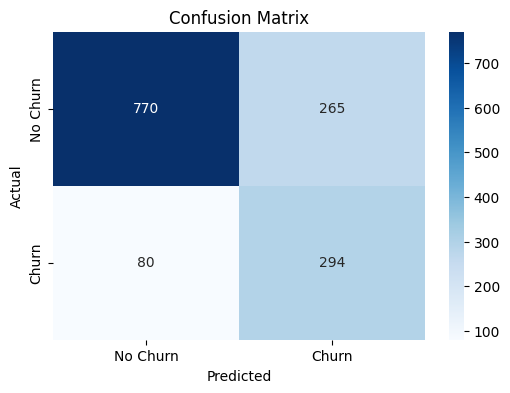

ROC AUC Score: 0.8383


In [7]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

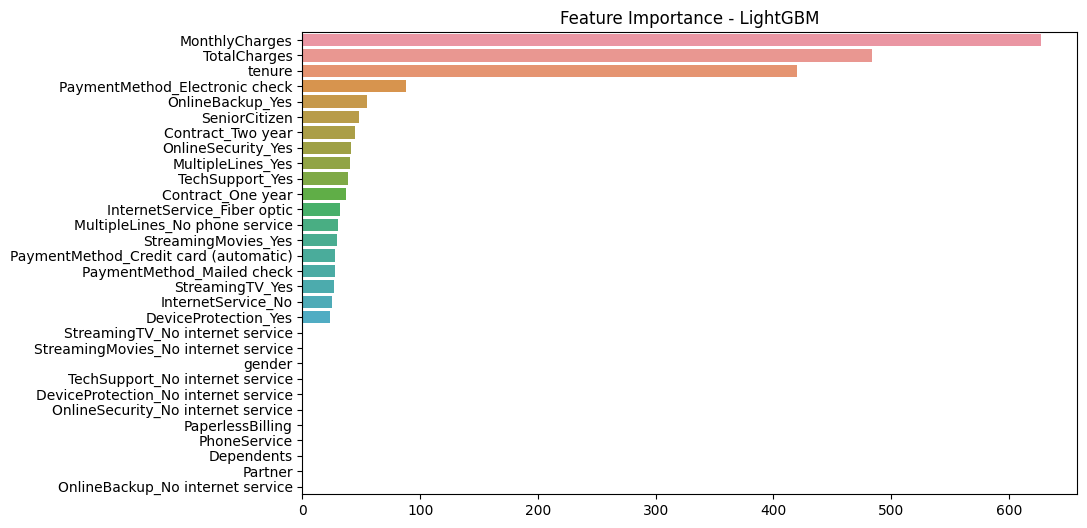

In [8]:
importances = model.feature_importances_
features = X.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()

In [9]:
joblib.dump(model, './models/lgbm_model.pkl')
print("LightGBM model saved to './models/lgbm_model.pkl'")

LightGBM model saved to './models/lgbm_model.pkl'
